
<h2 id="data_class">CNN model to identify brain Tumors</h2>

    Created by Rafael A.H. in Oct. 2024
    Dataset by Preet Viradiya from Kaggle 2021

Convolutional neural network created with pytorch to detect and classify brain tumors from MRI scans

1.- Libraries>>>

In [1]:
#------------------------------------------------------------Libraries----------------------------------------------------------------
#Data Manipulation (General)
import matplotlib.pylab as plt                         
import numpy as np                                      
import os                                               
import pandas as pd
from PIL import Image
import pathlib
import itertools 

#Data Manipulation (Pytorch)
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
import torchvision
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision import utils
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

#Pytorch model
import torch
import torch.nn as nn
from torch import optim

2.- Data obtention, I call upon the Dataset to bring forth the images which will be used to train and validate the model

In [2]:
#------------------------------------------------------------------------------------------------------------------------------------------
#Data call
Metadata_DF = pd.read_csv('metadata.csv')
print(Metadata_DF.head())

   Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)


With this information I have decided to work with jpg images which have a shape of 512x512 in RGB so 3 dimensions

Here is a function to transform the data and work with the images in any position, as well as transforming them to tensors and normalize them with the standars values of an RGB Image

In [3]:
#------------------------------------------------------------------------------------------------------------------------------------------
#Data transformation
transform = transforms.Compose(
    [
        transforms.Resize((512,512)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]) #Values standard for RGB
   ]
)

For this part I am going to merge the images in one defining as positive those images where is a tumor and negative those which are healthy.

In [4]:
#Image and data merge
dir=''
positive="Brain Tumor"
negative='Healthy'

positive_file_path=os.path.join(dir,positive)
negative_file_path=os.path.join(dir,negative)
positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]

# Ensure both lists have the same length
min_length = min(len(positive_files), len(negative_files))
positive_files = positive_files[:min_length]
negative_files = negative_files[:min_length]

number_of_samples=len(positive_files)+len(negative_files)
print("Number of samples: ",number_of_samples)

all_files=[None]*number_of_samples
all_files[::2]=positive_files
all_files[1::2]=negative_files

#torch.LongTensor setting my Y output where 1 is Brain Tumor and 0 is a healthy image
Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
Y[::2]=1
Y[1::2]=0

#Splitting data for training I will use 80% of the dataset and for validation I will use the other 20%
train_size = int(0.8 * number_of_samples)
val_size = number_of_samples - train_size

train_files, val_files = all_files[:train_size], all_files[train_size:]
train_labels, val_labels = Y[:train_size], Y[train_size:]

print("Training samples: ", len(train_files))
print("Validation samples: ", len(val_files))

Number of samples:  4148
Training samples:  3318
Validation samples:  830


Applying the transformation for the images and crating dataloaders

In [5]:
# Setting up the transformation and data loader of the images

# Custom dataset class to apply transformations
class BrainTumorDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets
train_dataset = BrainTumorDataset(train_files, train_labels, transform=transform)
val_dataset = BrainTumorDataset(val_files, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)




Lets take a peak at some images to see if I did it right

Images shape: torch.Size([32, 3, 512, 512])
Labels shape: torch.Size([32])


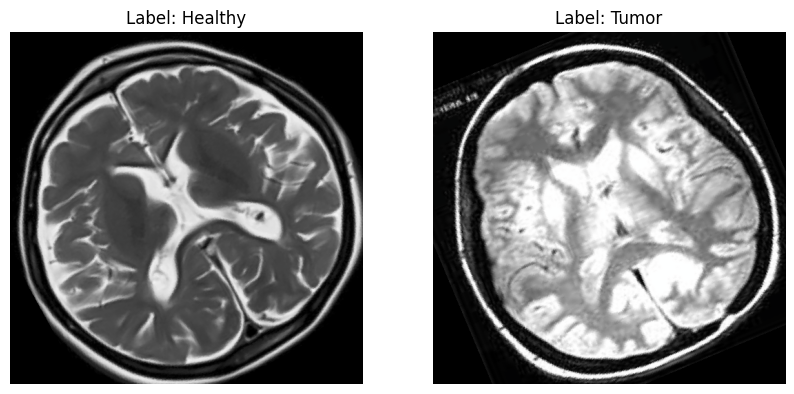

In [7]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print shapes to debug
print("Images shape:", images.shape)  # Should be (batch_size, C, H, W)
print("Labels shape:", labels.shape)   # Should be (batch_size,)

# Plot the images
num_images = min(2, len(images))  # Handle case when there are fewer than 2 images
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

for idx in range(num_images):
    image = images[idx].numpy().transpose((1, 2, 0))
    
    # Check for NaN or invalid values
    if np.any(np.isnan(image)) or np.any(np.isinf(image)):
        print("Invalid values found in image.")

    # Unnormalize
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    
    axes[idx].imshow(image)
    axes[idx].set_title(f"Label: {'Tumor' if labels[idx] == 1 else 'Healthy'}")
    axes[idx].axis('off')

plt.show()


3.- Time to set and create the CNN model, 
but here is the trick, there are several architectures for Convolutional neural networks classics like resnet or VGG have been used for image recognition for quite a while, I could do a model from scratch but in this case I want to try approaching this dataset with Densely connected Networks architcture and I hope that my laptop survives. 

#First of all I have decided to use DenseNetworks but using only 3 dense blocks 2 transition layers and a lot of faith
<body>
<br>
----------------------------------------------------------------------------------------------------------------------------------------<br>
Input → Conv2D → BatchNorm → ReLU <br>
    &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Dense Block 1<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Transition Layer<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Dense Block 2<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Transition Layer<br>
      &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Dense Block 3<br>
       &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Global Average Pooling<br>
       &nbsp;&nbsp;&nbsp;&nbsp; ↓<br>
   Fully Connected Layer (Output)<br>
   </body>
   ---------------------------------------------------------------------------------------------------------------------------------------

*Transition Class*

In [8]:
#First I define the transition class for an average pooling of 2x2 and convoluttions 1x1 with relu as activation function
# to mantain the size of the feature map between transitions 

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


*Dense Layers Class*

In [9]:
#Each Dense block has dense layers so lets define them

# The convolution operation is performed to get new_features which are of size K or growth_rate.
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        
        # The first batch normalization and activation is for the input features
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        
        # Bottleneck convolution 
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False))
        
        # Then this second batch normalization and activation is for the bottleneck output
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        
        # I add a convolution for the growth output
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1 bias=False))
        
        # A little bit of optimization here
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient
        
    # The DenseLayer accepts an input, then it concatenates the input together and get bottleneck_output 
    def bn_function(self, inputs):
        "Bottleneck function"
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  
        return bottleneck_output

    # The forward function processes the input through a bottleneck layer followed by a convolution layer to obtain the new features
    def forward(self, input):  
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

*Dense block Class*

In [11]:
# The denseblock class will consist of multiple denselayers 

class _DenseBlock(nn.ModuleDict):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        
        # Here is the loop to create dense layer instances for each dense block defined
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    # Now lets define how the input data flows through the DenseBlock during the forward pass of the neural network.
    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

*Dense Network Class*

In [ ]:
#The DenseNet class is a implementation of the DenseNet architecture, which main features I defined in the previous class

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # Convolution and pooling part from table-1
        self.features = nn.Sequential(torch.OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Add multiple denseblocks based on config 
        # for densenet-121 config: [6,12,24,16]
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

4.- Training the dataset: for now I have defined the training loader and the validation loader with a batch of 32 and a learning rate of 

In [ ]:

#------------------------------------------------------------------------------------------------------------------------------------------
#Training





#------------------------------------------------------------------------------------------------------------------------------------------
#Evaluating


#------------------------------------------------------------------------------------------------------------------------------------------
#Visualisation


#------------------------------------------------------------------------------------------------------------------------------------------